In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn import model_selection, preprocessing,linear_model, metrics, pipeline

plt.style.use("ggplot")
plt.rcParams['figure.figsize'] = [10.0, 6.0]

%matplotlib inline

In [2]:
train = pd.read_csv('../../datasets/titanic/train.csv')
test = pd.read_csv('../../datasets/titanic/test.csv')

In [3]:
train['Pclass'] = train['Pclass'].astype('object')
test['Pclass'] = test['Pclass'].astype('object')

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null object
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(4), object(6)
memory usage: 83.6+ KB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null object
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(3), object(6)
memory usage: 36.0+ KB


In [6]:
target = 'Survived'
features = list(train.columns)
features.remove('PassengerId')
features.remove('Name')
features.remove('Cabin')
features.remove('Ticket')
features.remove(target)
features , target

(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'], 'Survived')

In [7]:
medians = train.dropna().groupby('Sex')['Age'].median()
for i in train[train['Age'].isnull()].index:
    train.loc[i,'Age'] = medians[train.loc[i,'Sex']]
    
for i in test[test['Age'].isnull()].index:
    test.loc[i,'Age'] = medians[test.loc[i,'Sex']]
    
fare_mean = train.Fare.mean()
for i in test[test['Fare'].isnull()].index:
    test.loc[i,'Fare'] = fare_mean

In [8]:
test[test['Fare'].isnull()].index

Int64Index([], dtype='int64')

In [10]:
def preprocess(df,features = None,target = None):
    X = df.loc[:,features]
    X = pd.get_dummies(X, drop_first= True)
    y = []
    if target != None:
        y = df.loc[:,target]
    
    return X,y

In [11]:
def train_model(train_X,train_y,test_X):
    est = pipeline.Pipeline([
        #("poly", preprocessing.PolynomialFeatures(degree=1, include_bias=False)),
        ("scaler", preprocessing.StandardScaler()),
        ("lr", linear_model.LogisticRegression(random_state=1,penalty='l1'))
    ])
    est.fit(train_X,train_y)

    y_train_pred = est.predict(train_X)
    y_train_prob = est.predict_proba(train_X)[:,1]
    
    y_test_pred = est.predict(test_X)
    y_test_prob = est.predict_proba(test_X)[:,1]
    return y_train_prob,y_test_prob

In [12]:
def print_val(y_test,y_pred_prob,threshold = 0.5):
    y_test_pred = np.where(y_pred_prob > threshold , 1, 0)
    
    print("Accuracy :: %.3f" % metrics.accuracy_score(y_true=y_test,y_pred=y_test_pred))
    print("Precision :: %.3f" % metrics.precision_score(y_true=y_test,y_pred=y_test_pred))
    print("Recall :: %.3f" % metrics.recall_score(y_true=y_test,y_pred=y_test_pred))
    
    confusion_matrix = metrics.confusion_matrix(y_true=y_test,y_pred=y_test_pred)
    print(confusion_matrix)
    return
    

In [13]:
X,y = preprocess(train,features=features,target=target)

In [14]:
X.shape,y.shape

((891, 9), (891,))

In [15]:
X.head()

,Age,SibSp,Parch,Fare,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S
0,22.0,1,0,7.2500,0,1,1,0,1
1,38.0,1,0,71.2833,0,0,0,0,0
2,26.0,0,0,7.9250,0,1,0,0,1
3,35.0,1,0,53.1000,0,0,0,0,1
4,35.0,0,0,8.0500,0,1,1,0,1


In [16]:
X_train, X_test, y_train,y_test = model_selection.train_test_split(X,y, test_size = 0.3, random_state = 1)
y_train_prob,y_test_prob = train_model(X_train,y_train,X_test)

Text(0.5,1,'ROC, auc: 0.825263')

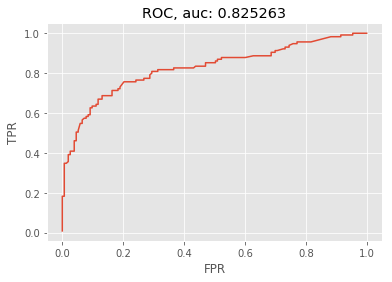

In [17]:
fpr, tpr, threshold = metrics.roc_curve(y_test, y_test_prob)

plt.plot(fpr, tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC, auc: %f" % (metrics.auc(fpr, tpr)))

In [18]:
print("--------Train------------")
print_val(y_train,y_train_prob,0.4)
print("--------Test------------")
print_val(y_test,y_test_prob,0.4)

--------Train------------
Accuracy :: 0.812
Precision :: 0.731
Recall :: 0.767
[[332  64]
 [ 53 174]]
--------Test------------
Accuracy :: 0.772
Precision :: 0.745
Recall :: 0.713
[[125  28]
 [ 33  82]]


In [19]:
X_submission,y_submission = preprocess(test,features=features)

In [20]:
a,y_submission_prob = train_model(train_X = X,train_y=y,test_X=X_submission)
y_test_pred = np.where(y_submission_prob > 0.4 , 1, 0)

In [21]:
test.shape,len(y_test_pred),len(a),len(y_submission_prob),X_submission.shape

((418, 11), 418, 891, 418, (418, 9))

In [22]:
test['Survived'] = y_test_pred

In [23]:
test.sample(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
98,990,3,"Braf, Miss. Elin Ester Maria",female,20.0,0,0,347471,7.8542,NaN,S,1
128,1020,2,"Bowenur, Mr. Solomon",male,42.0,0,0,211535,13.0000,NaN,S,0
325,1217,3,"Assam, Mr. Ali",male,23.0,0,0,SOTON/O.Q. 3101309,7.0500,NaN,S,0
371,1263,1,"Wilson, Miss. Helen Alice",female,31.0,0,0,16966,134.5000,E39 E41,C,1
394,1286,3,"Kink-Heilmann, Mr. Anton",male,29.0,3,1,315153,22.0250,NaN,S,0


In [24]:
submission = pd.read_csv('../../datasets/titanic/gender_submission.csv')
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [27]:
test[['PassengerId','Survived']].to_csv("gender_submission.csv",index=False)